In [1]:
from qtn.maxkappa import MaxKappa
from qtn.util import (boltzmann, emass, echarge, permittivity, cspeed, fperp, fp, timing)
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from scipy.io.idl import readsav
%matplotlib inline
import os

In [2]:
ant_len = 50      # m (monopole) 
ant_rad = 1.9e-4  # m
base_cap = 20e-12 # Fara
fbins = np.array([4000*2**((2*i+1)/32) for i in range(96)])

In [3]:
home = os.path.expandvars('$HOME')
wind_data = readsav(home + '/Google Drive/research/new_data/idlsave_param_electron_19970110.sav')
m_dat=readsav(home + '/Google Drive/research/data/meudon_tnr/TNR_XY_ACE_19970110.sav')
m_data=m_dat['data']
mt = m_data['timeur8'][0]
mtag = m_data['time'][0]
quality = wind_data['quality']
qualified = np.where(quality>0)[0]

In [4]:
wind_data.keys()

dict_keys(['tp', 'ns', 'nh', 'time', 'netnr', 'vsw', 'time_in_string', 'th', 'quality', 'kh', 'ephi', 'ts', 'tc', 'nc'])

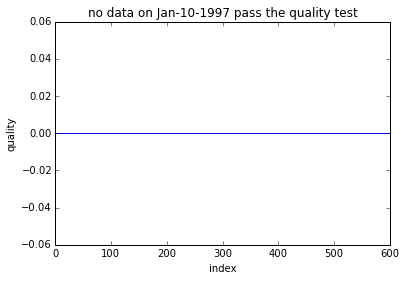

In [5]:
plt.plot(quality)
plt.xlabel("index")
plt.ylabel("quality")
plt.title("no data on Jan-10-1997 pass the quality test")
plt.show()

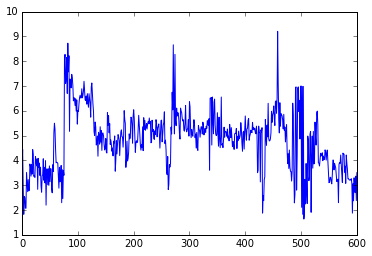

In [6]:
plt.plot(wind_data['ephi'])

In [7]:
@timing
def sample(i, wind_data, mt, m_data):
    tc = float(wind_data['tc'][i])
    tp = float(wind_data['tp'][i])
    th = float(wind_data['th'][i])
    ts = float(wind_data['ts'][i])
    nc = float(wind_data['nc'][i])
    nh = float(wind_data['nh'][i])
    ns = float(wind_data['ns'][i])
    ## use halo + strahl" as halo
    nh = nh + ns
    netnr = float(wind_data['netnr'][i])
    k = float(wind_data['kh'][i])
    ephi = wind_data['ephi'][i]
    vsw = float(wind_data['vsw'][i]) * 1000
    time = float(wind_data['time'][i])
    time_string = wind_data['time_in_string'][i].decode("utf-8").split('/')
    time_string = time_string[0] + '-' + time_string[1]
    ne = nc + nh + ns
    ne = nc + nh
    n = nh/nc
    t = th/tc
    fpe = np.sqrt(echarge**2 * ne * 1e6 /emass/permittivity)/2/np.pi
    day_3dp = round(float(wind_data['time'][0])/24/3600)
    time_3dp = time/24/3600 - day_3dp
    
    # index of the closest spectrum
    day_tnr = round(mt[0])
    ind = np.abs(mt-day_tnr-time_3dp).argmin()
    print(ind)
    
    # spectrum 
    spec = m_data['spectra'][0][:,ind]
    spec = 10. ** (spec/10.)
    
    # texts in the plot
    texts = "{0}{1:.2e}\n".format(r'$V_{sw}=$',vsw) + \
    "{0}{1:.2f}\n".format(r'$n_c=$',nc) + \
    "{0}{1:.2f}\n".format(r'$n_h=$',nh) + \
    "{0}{1:.2f}\n".format(r'$n_s=$',ns) + \
    "{0}{1:.2f}\n".format(r'$nn=$',netnr) + \
    "{0}{1:.2f}\n".format(r'$T_c=$',tc) + \
    "{0}{1:.2f}\n".format(r'$T_h=$',th) + \
    "{0}{1:.2f}\n".format(r'$n_h=$',nh) + \
    "{0}{1:.2f}\n".format(r'$\phi=$',ephi) + \
    "{0}{1:.2f}".format(r'$\kappa=$',k)
    
    p = MaxKappa(ant_len, ant_rad, base_cap)
    za_zr = np.array([np.array(p.impedance(f, ne, n, t, tp, tc, k, vsw)) for f in fbins])
    za = za_zr[:, 0]
    zr = za_zr[:, 1]
    gain = np.abs((za+zr)/zr)**2

    def helper(f):
        """
        control precision when calculating electron noise.
        """
        if f < fpe or f > 1.2 * fpe:
            mp.mp.dps = 20
        else:
            mp.mp.dps = 40
        val = p.electron_noise(f, ne, n, t, tp, tc, k, vsw)
        mp.mp.dps= 15
        return val

    e_noise = np.array([helper(f) for f in fbins])
    p_noise = np.array([p.proton(f, ne, n, t, tp, tc, k, vsw) for f in fbins])
    
    def shot(za, ephi):
        """
        
        """
        _vtc = np.sqrt(2 * echarge * tc/emass)
        _nc = nc * 1e6
        _ne = _nc * _vtc * (1 + n * mp.sqrt(t)) * 2 * np.pi * ant_rad * ant_len / np.sqrt(4 * np.pi)
        A = 1 + ephi/tc
        return 2 * A * echarge**2 * np.abs(za)**2 * _ne 

    s_noise = np.array([shot(_za, ephi) for _za in za])
    
    # making the plot
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')
    fig = plt.figure(figsize=[6, 6])
    plt.plot(fbins/1000, (e_noise + p_noise + s_noise)/gain, label='3DP + theory')
    plt.plot(fbins/1000, spec, 'o', markersize=2, label='TNR')
    plt.plot(fbins/1000, e_noise/gain,'--', label='electron')
    plt.plot(fbins/1000, p_noise/gain, '-.', label='proton')
    plt.plot(fbins/1000, s_noise/gain, '--', label='shot')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([4, 256])
    plt.ylim([1e-18, 1e-10])
    plt.xlabel(r'$f[kHz]$')
    plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
    plt.title(time_string)
    plt.legend(loc='best')
    plt.annotate(texts, xy=(0.05, 0.05), xycoords='axes fraction', fontsize=10)
    plt.show()
    # save the figure
    fig.savefig('survey/survey_plot/wind' + '-' + time_string +'.png', dpi=300)
    # save calculation result
    np.savez('survey/survey_data/wind' + '-' + time_string, 
             p_noise=p_noise, e_noise = e_noise, 
             s_noise = s_noise, gain = gain, za = za, zr= zr,
             nc = nc, nh = nh, ns = ns, tc = tc, th = th, k = k, vsw = vsw,
             ephi = ephi)

In [8]:
def sample_helper(index):
    return sample(index, wind_data, mt, m_data)

### select samples

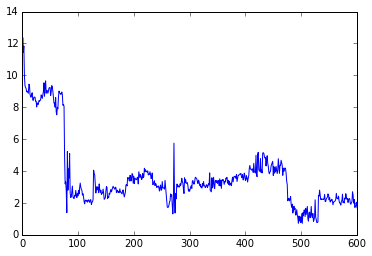

In [9]:
plt.plot(wind_data['tc'])
plt.show()

In [10]:
num_samples = wind_data['tc'].size
print(num_samples)

601


In [12]:
#sample_index = [10, 50, 100, 200, 250, 300, 400, 499, 500, 501, 550, 600]
sample_index = [10, 100, 300, 400, 499, 500, 550, 600]
wind_data['tc'][sample_index]

array([ 8.94618607,  2.4445436 ,  2.72170734,  3.40580177,  0.76897311,
        0.78730959,  2.18974066,  1.69825554], dtype=float32)

### multithreading version for some speedup

In [13]:
from multiprocessing import Pool
pool = Pool()
pool.map(sample_helper, sample_index)
pool.close()
pool.join()

2979
25314
19752
9179
%s function took %0.3f ms sample 1005502.8729438782
%s function took %0.3f ms sample 1017918.683052063
%s function took %0.3f ms sample 997086.5399837494
%s function took %0.3f ms sample 815801.1379241943
34478
38611
30631
30586
%s function took %0.3f ms sample 778277.83203125
%s function took %0.3f ms sample 754924.4101047516
%s function took %0.3f ms sample 735771.8970775604
%s function took %0.3f ms sample 777348.2630252838
